# Perceptron

A **perceptron** is the simplest linear binary classifier and the historical foundation of neural networks (Rosenblatt, 1958). This notebook implements the classic **online perceptron** on the Iris dataset and covers the key theory behind it.

In [1]:
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Reproducibility
np.random.seed(42)
torch.manual_seed(0)

## 1. Data

We use the **Iris dataset** as a binary classification task: *setosa* (+1) vs. *versicolor/virginica* (−1). Only two features are used so the decision boundary can be plotted in 2D. Setosa is linearly separable from the other two classes on these features, which guarantees perceptron convergence.

In [ ]:
iris = datasets.load_iris()

# Use 2 features for 2D visualization: sepal and petal length
X = iris.data[:, [0, 2]].astype(np.float32)  # shape: (150, 2)

# Perceptron expects +1 / -1 labels 
y = np.where(iris.target == 0, 1, -1).astype(np.float32)  # setosa=+1, others=-1

print("X shape:", X.shape)
print("y unique values:", np.unique(y))

X shape: (150, 2)
y unique values: [-1.  1.]


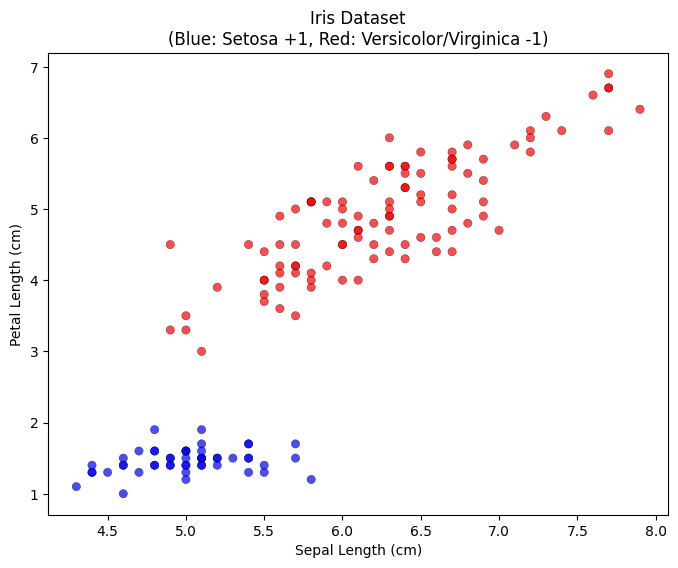

In [3]:
# Visualize the raw data before training
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['blue' if label == 1 else 'red' for label in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.7, edgecolors='k', linewidths=0.3)
ax.set_xlabel('Sepal Length (cm)')
ax.set_ylabel('Petal Length (cm)')
ax.set_title('Iris Dataset\n(Blue: Setosa +1, Red: Versicolor/Virginica -1)')
plt.show()

## Perceptron Algorithm

A perceptron is a linear binary classifier. It learns a weight vector **w** and bias **b** such that:

$$\hat{y} = \text{sign}(\mathbf{w}^T \mathbf{x} + b)$$

**Update rule** (classic perceptron): for each misclassified sample $(x_i, y_i)$:
$$\mathbf{w} \leftarrow \mathbf{w} + y_i \mathbf{x}_i, \quad b \leftarrow b + y_i$$

**Loss** (differentiable hinge form, used for SGD):
$$\mathcal{L} = \max(0,\ -y \cdot \hat{y})$$

This is 0 for correctly classified points and positive for mistakes.

## Perceptron Convergence Theorem (Novikoff, 1962)

If the data is linearly separable, the number of mistakes is bounded by:

$$\text{mistakes} \leq \left(\frac{R}{\gamma}\right)^2$$

where:
- $R = \max_i \|\mathbf{x}_i\|$ — **radius** of the data (how far points are from the origin)
- $\gamma = \min_i\, y_i\,(\mathbf{w}^* \cdot \mathbf{x}_i)$ — **margin** of the best linear separator $\mathbf{w}^*$

**Key properties:**
- The bound is **independent of $n$** — only geometry matters, not dataset size
- Large margin $\gamma$ → fewer mistakes (classes are well separated)
- Large radius $R$ → more mistakes (data spread far from origin, harder geometry)
- If data is **not** linearly separable, the algorithm never terminates

## Pros and Cons

**Pros:**
- **Simple** — one weight update per misclassified sample, no hyperparameter tuning beyond lr
- **Online** — processes one sample at a time; works with streaming data and large datasets that don't fit in memory
- **Guaranteed convergence** — if data is linearly separable, it finds a solution in finite steps (Novikoff)
- **Computationally cheap** — just a dot product and an addition per update, no matrix ops

**Cons:**
- **Requires linear separability** — diverges forever if classes aren't linearly separable; no built-in stopping criterion
- **No unique solution** — which hyperplane you get depends on initialization and sample order; not necessarily the *best* one
- **No margin maximization** — SVM finds the maximum-margin boundary; perceptron finds *any* boundary, which may generalize poorly
- **Sensitive to feature scale** — large $R$ inflates the mistake bound; features should be normalized
- **Binary only** — natively handles two classes; multi-class requires extensions (one-vs-rest, etc.)
- **No probability output** — gives a hard $\pm 1$ decision, no confidence score

> The SVM directly addresses the biggest weakness: it optimizes for the maximum margin, giving a unique, stable, and better-generalizing solution — at the cost of solving a quadratic program instead of a simple online loop.

## 2. Model & Loss

We use `nn.Linear` (a single layer with no activation) to represent $\hat{y} = \mathbf{w}^T \mathbf{x} + b$. This is equivalent to the classic perceptron but lets PyTorch handle gradient computation via autograd, avoiding manual weight update bookkeeping.

In [ ]:
# A single linear layer: computes w^T x + b
# in_features=2 matches our 2-feature input; out_features=1 gives one score per sample
perceptron = torch.nn.Linear(in_features=2, out_features=1, bias=True)


def perceptron_loss(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Hinge loss: max(0, -y * y_hat).
    
    - y_true: +1 or -1 labels
    - y_pred: raw linear output (not passed through sign, so gradients flow)
    - Loss is 0 when y and y_pred agree in sign; positive otherwise.
    """
    return torch.relu(-y_true * y_pred).mean()

## 3. Training

The **online update loop** processes one sample at a time — the defining property of the classic perceptron. With `lr=1.0` and `momentum=0`, each SGD step on the hinge loss is mathematically identical to the hand-written rule $\mathbf{w} \leftarrow \mathbf{w} + y_i \mathbf{x}_i$: the update only fires on misclassified samples (where loss > 0), and does nothing on correct ones (where loss = 0, gradient = 0).

In [5]:
# Convert numpy arrays to tensors
# y needs shape (N, 1) to broadcast correctly against the (N, 1) output of nn.Linear
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y).unsqueeze(1)

# lr=1.0 matches the classic perceptron update magnitude; momentum=0 keeps it pure
optimizer = torch.optim.SGD(perceptron.parameters(), lr=1.0, momentum=0.0)

n_epochs = 2

for epoch in range(n_epochs):
    epoch_loss = 0.0

    # Online update: process one sample at a time (classic perceptron style)
    for i in range(len(X_tensor)):
        xi = X_tensor[i].unsqueeze(0)  # shape (1, 2)
        yi = y_tensor[i].unsqueeze(0)  # shape (1, 1)

        # Forward pass on a single sample
        y_hat = perceptron(xi)
        loss = perceptron_loss(yi, y_hat)

        # Backward pass and weight update per sample
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(X_tensor)
    print(f"Epoch {epoch + 1}/{n_epochs} | Avg Loss: {avg_loss:.4f}")

w = perceptron.weight.detach().numpy()[0]
b = perceptron.bias.detach().numpy()[0]
print(f"\nFinal weights: {w}, bias: {b:.4f}")

Epoch 1/2 | Avg Loss: 0.2968
Epoch 2/2 | Avg Loss: 0.2001

Final weights: [-3.805294 -6.220677], bias: -0.5820


## 4. Results

The decision boundary is the line $\mathbf{w}^T \mathbf{x} + b = 0$ — points on one side are classified +1, the other −1. Because the classes are linearly separable, the perceptron finds a valid boundary in just 2 epochs.

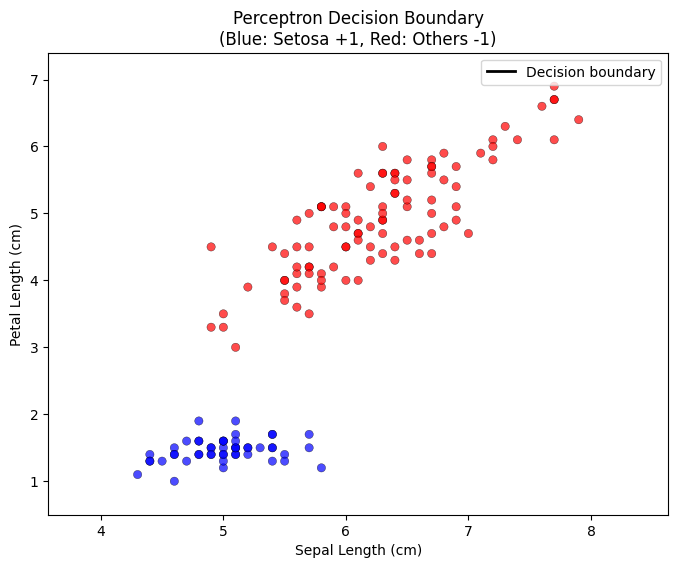

In [6]:
# Visualize the learned decision boundary
with torch.no_grad():
    w = perceptron.weight.numpy()[0]   # shape (2,)
    b = perceptron.bias.numpy()[0]     # scalar

    # Decision boundary: w[0]*x0 + w[1]*x1 + b = 0  =>  x1 = -(w[0]*x0 + b) / w[1]
    x0_range = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 200)
    x1_boundary = -(w[0] * x0_range + b) / w[1]

fig, ax = plt.subplots(figsize=(8, 6))
colors = ['blue' if label == 1 else 'red' for label in y]
ax.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.7, edgecolors='k', linewidths=0.3)
ax.plot(x0_range, x1_boundary, 'k-', linewidth=2, label='Decision boundary')
ax.set_xlabel('Sepal Length (cm)')
ax.set_ylabel('Petal Length (cm)')
ax.set_title('Perceptron Decision Boundary\n(Blue: Setosa +1, Red: Others -1)')
ax.legend()
ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.show()